# **Decision Trees for Regression**

## Imports

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text

In [2]:
np.random.seed(306)

In [3]:
cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

## Loading dataset

In [4]:
features,labels=fetch_california_housing(as_frame=True,return_X_y=True)

com_train_features,test_features, com_train_labels,test_labels=train_test_split(
    features, labels,random_state=42
)

In [5]:
train_features,dev_features,train_labels,dev_labels=train_test_split(
    com_train_features,com_train_labels,random_state=42
)

## Model Setup

In [6]:
dt_reg_pipeline=Pipeline([
                           ('feature_scaling',StandardScaler()),
                           ('dt_reg',DecisionTreeRegressor(max_depth=3,random_state=42))
])

dt_reg_cv_results=cross_validate(dt_reg_pipeline,
                                 com_train_features,
                                 com_train_labels,
                                 cv=cv,
                                 scoring='neg_mean_absolute_error',
                                 return_train_score=True,
                                 return_estimator=True)

dt_reg_train_error=-1*dt_reg_cv_results['train_score']
dt_reg_test_error=-1*dt_reg_cv_results['test_score']

print(f'Mean absolute error of linear regression model on the train set:\n'
f'{dt_reg_train_error.mean():.3f}+/-{dt_reg_train_error.std():.3f}\n')

print(f'Mean absolute error of linear regression model on the test set:\n'
f'{dt_reg_test_error.mean():.3f}+/-{dt_reg_test_error.std():.3f}')

Mean absolute error of linear regression model on the train set:
0.590+/-0.005

Mean absolute error of linear regression model on the test set:
0.593+/-0.007


## Visualizing the tree

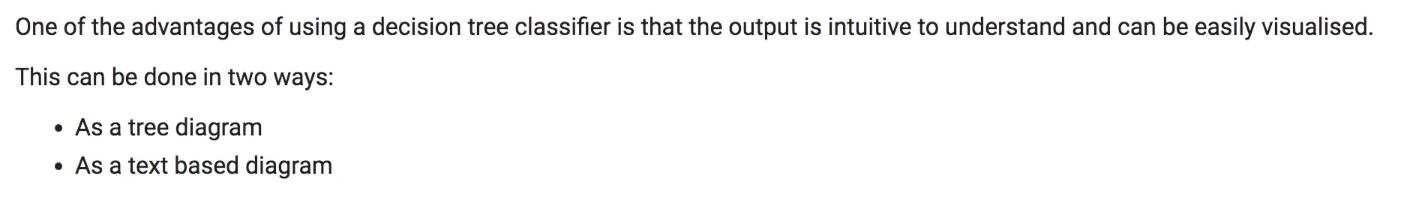

### As a tree diagram

In [7]:
dt_reg_pipeline.fit(train_features,train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

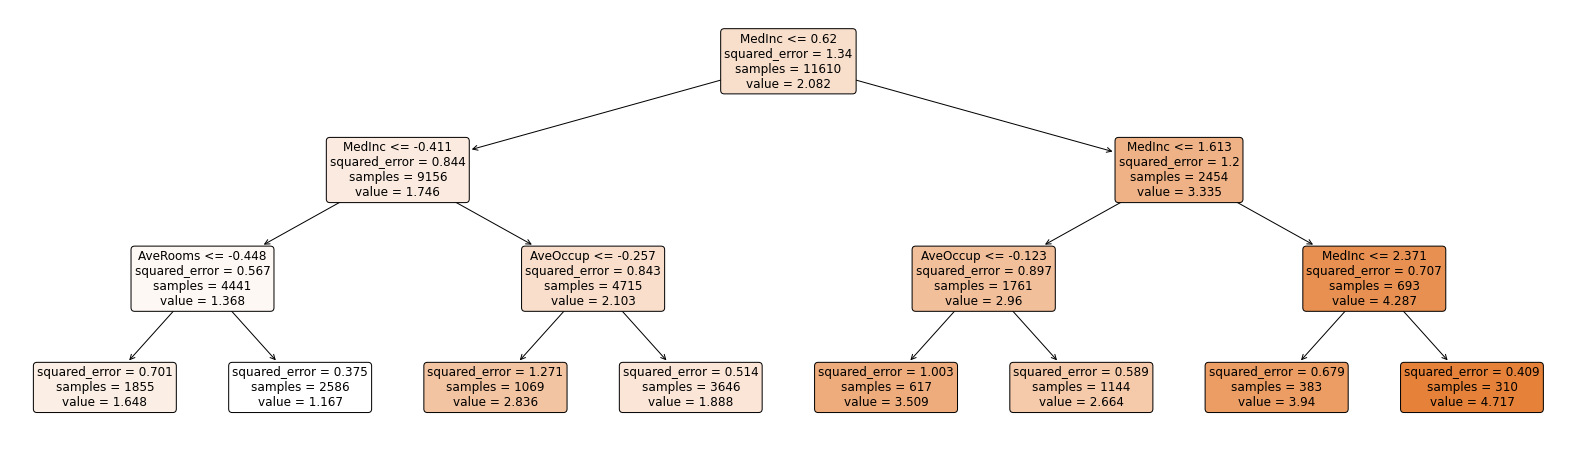

In [8]:
plt.figure(figsize=(28,8),facecolor='w')
a=tree.plot_tree(dt_reg_pipeline[-1],
                 feature_names=features.columns,
                 rounded=True,
                 filled=True,
                 fontsize=12)
plt.show()

### As a text based diagram

In [9]:
tree_rules=export_text(dt_reg_pipeline[-1])
print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



## Using the tree for prediction

In [10]:
test_label_pred=dt_reg_pipeline.predict(test_features)

## Evaluating the tree

In [11]:
mae=mean_absolute_error(test_labels,test_label_pred)
mse=mean_squared_error(test_labels, test_label_pred)
r2=r2_score(test_labels,test_label_pred)

print('\nMAE: ',mae, '\nMSE: ',mse,'\nR2: ',r2)


MAE:  0.6005762942842664 
MSE:  0.6417557936098145 
R2:  0.5150037690483743


In [12]:
param_grid={'dt_reg__max_depth':range(1,20),
            'dt_reg__min_samples_split':range(2,8)}
dt_grid_search=GridSearchCV(dt_reg_pipeline,
                            param_grid=param_grid,
                            n_jobs=2,
                            cv=cv,
                            scoring='neg_mean_absolute_error',
                            return_train_score=True)
dt_grid_search.fit(com_train_features,com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [13]:
mean_train_error=-1*dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error=-1*dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error=dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error=dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]

print(f'Best Mean absolute error of linear regression model on the train set:\n'
f'{mean_train_error:.3f}+/-{std_train_error:.3f}\n')

print(f'Mean absolute error of linear regression model on the test set:\n'
f'{mean_test_error:.3f}+/-{std_test_error:.3f}')

Best Mean absolute error of linear regression model on the train set:
0.278+/-0.006

Mean absolute error of linear regression model on the test set:
0.428+/-0.012


In [14]:
print('Mean cross val score of best parameter: ',-1*dt_grid_search.best_score_)

Mean cross val score of best parameter:  0.4283313044233501


In [15]:
print('Best parameter value: ',dt_grid_search.best_params_)

Best parameter value:  {'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}


In [16]:
dt_reg_pipeline.set_params(
    dt_reg__max_depth=11,dt_reg__min_samples_split=5
).fit(com_train_features,com_train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

In [17]:
test_labels_pred=dt_reg_pipeline.predict(test_features)
mae=mean_absolute_error(test_labels,test_label_pred)
mse=mean_squared_error(test_labels, test_label_pred)
r2=r2_score(test_labels,test_label_pred)
print('\nMAE: ',mae, '\nMSE: ',mse,'\nR2: ',r2)


MAE:  0.6005762942842664 
MSE:  0.6417557936098145 
R2:  0.5150037690483743


# **Decision Trees for Classification - Abalone**

## Import Libraries

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

## Loading data

In [20]:
column_names=['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']
abalone_data=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',header=None,names=column_names)

In [21]:
abalone_data

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [22]:
type(abalone_data)

pandas.core.frame.DataFrame

In [23]:
abalone_data.shape

(4177, 9)

In [25]:
abalone_data.head(10)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


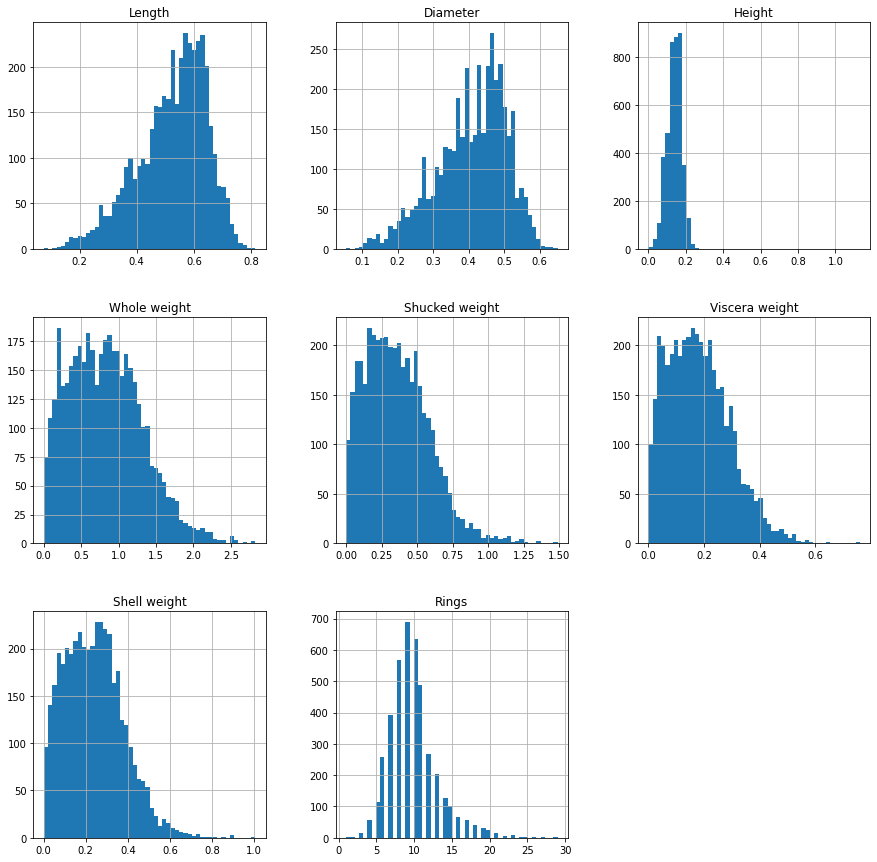

In [26]:
abalone_data.hist(bins=50,figsize=(15,15))
plt.show()

<Figure size 432x288 with 0 Axes>

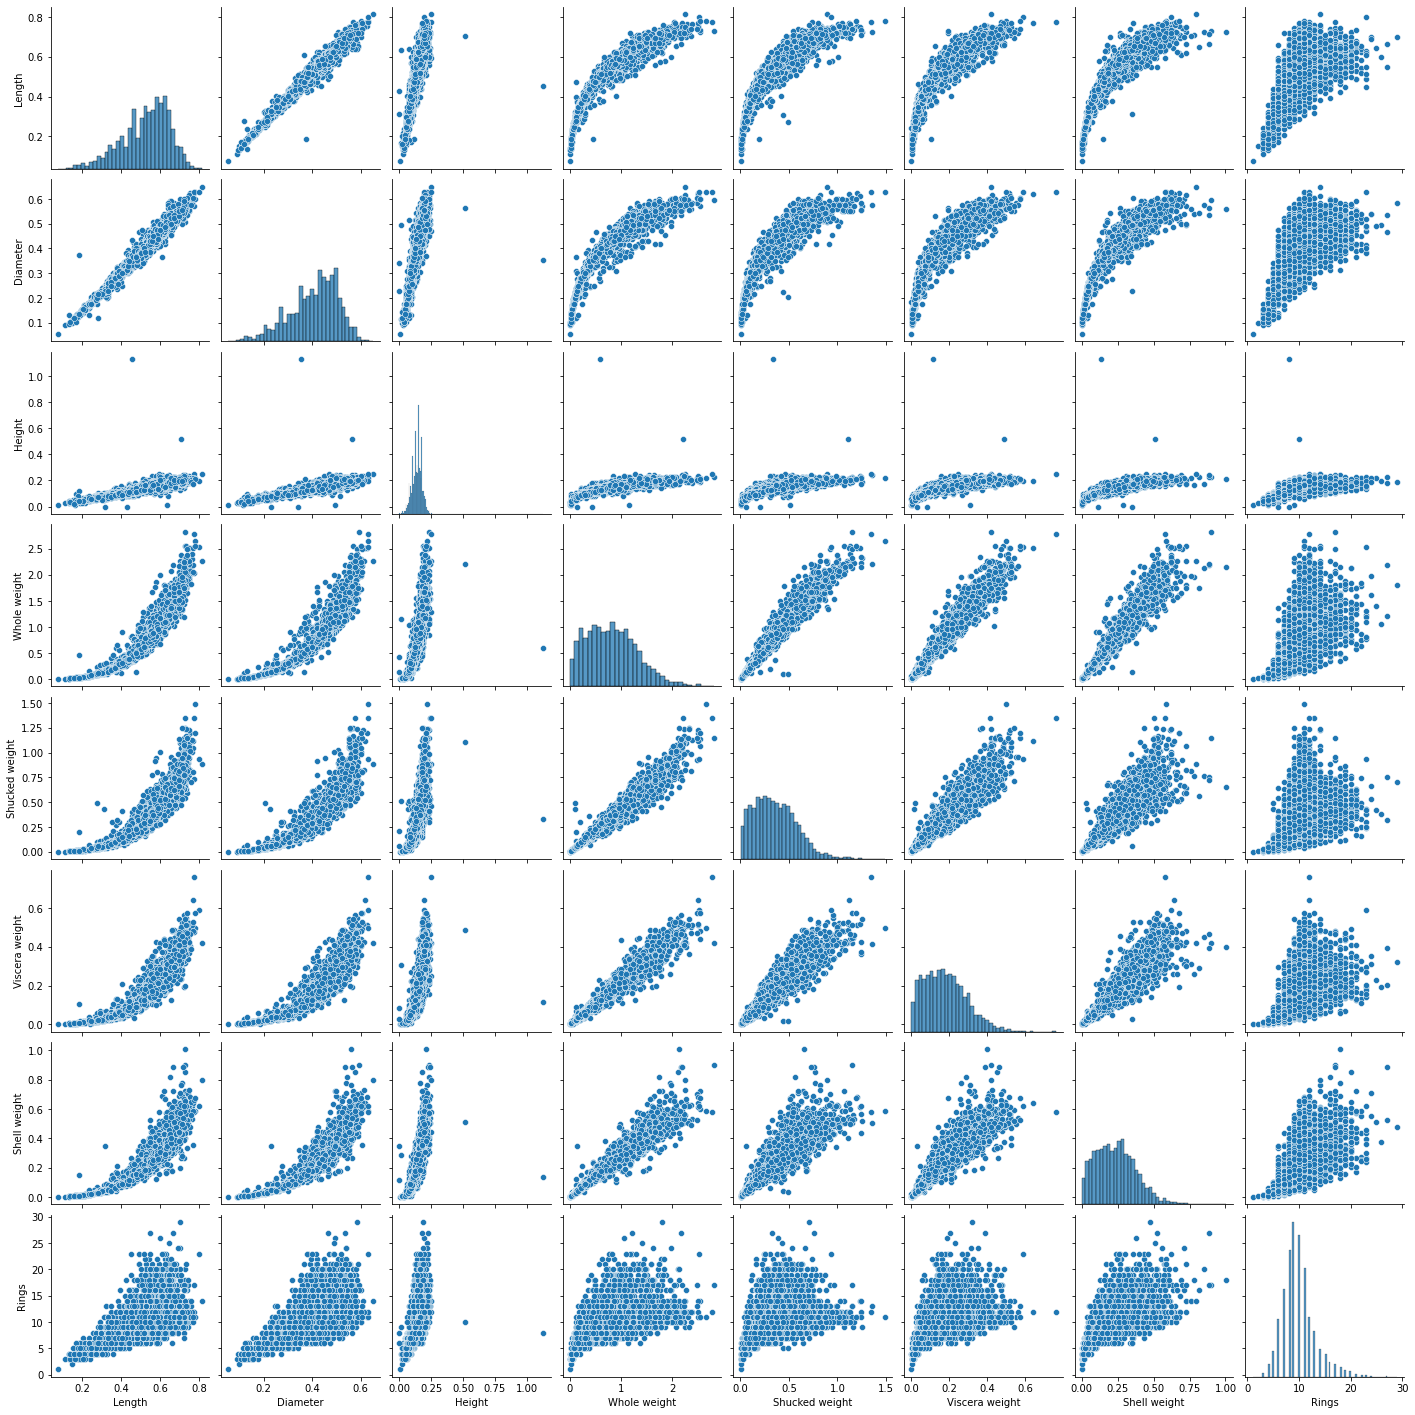

In [28]:
plt.figure()
sns.pairplot(abalone_data,diag_kind='hist')
plt.show()

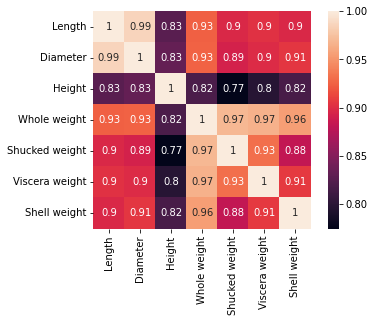

In [29]:
plt.figure()
sns.heatmap(abalone_data.iloc[:,:-1].corr(),annot=True,square=True)
plt.show()

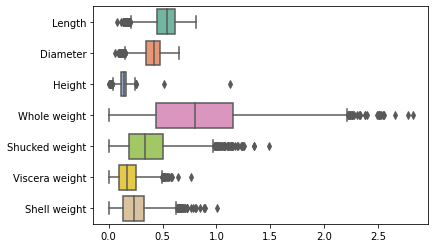

In [30]:
plt.figure()
sns.boxplot(data=abalone_data.iloc[:,:-1],orient='h',palette='Set2')
plt.show()

In [31]:
abalone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [32]:
abalone_data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [33]:
abalone_data['Rings'].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

In [34]:
abalone_data['Rings'].value_counts().sort_index()

1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
Name: Rings, dtype: int64

## Missing values(or 0 values)

In [35]:
(abalone_data['Height']==0).sum()

2

In [36]:
abalone_data[abalone_data['Height']==0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


In [38]:
means=pd.pivot_table(abalone_data,index=['Sex'],aggfunc={'Height':np.mean})
means

,Height
Sex,
F,0.158011
I,0.107996
M,0.151381


## Storing Data as X and y

In [39]:
X=abalone_data.iloc[:,:-1]
y=abalone_data.iloc[:,-1]

In [40]:
X[:5]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


## Split Train test data

In [41]:
X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               test_size=.2,
                                               random_state=0)

## Pipelining

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

In [43]:
numeric_features=['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
categorical_features=['Sex']

In [44]:
numeric_transformer=Pipeline(steps=[
                                    ('imputer',SimpleImputer(missing_values=0,strategy='constant',fill_value=0.107996)),
                                    ('scaler',StandardScaler())
])

In [45]:
categorical_transformer=OneHotEncoder(handle_unknown='ignore')

In [46]:
preprocessor=ColumnTransformer(
    transformers=[
                  ('num',numeric_transformer,numeric_features),
                  ('cat',categorical_transformer,categorical_features)
    ]
)

In [47]:
clf=Pipeline(
    steps=[
           ('preprocessing',preprocessor),
           ('classifier',DecisionTreeClassifier(
               max_depth=3,random_state=42
           ))
    ]
)

In [48]:
clf.fit(X_train,y_train)
print('Model score:%.3f'%clf.score(X_test,y_test))

Model score:0.245


In [49]:
y_pred=clf.predict(X_test)

In [50]:
comparison=np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1)

for each in comparison:
  print(each)

[10 13]
[8 8]
[10 11]
[4 5]
[10 12]
[10 11]
[9 7]
[8 8]
[7 7]
[10  9]
[7 8]
[5 8]
[ 9 11]
[8 9]
[5 4]
[10  7]
[9 7]
[10 17]
[10  7]
[7 7]
[7 7]
[7 5]
[8 8]
[9 9]
[10 10]
[10 10]
[4 5]
[11 15]
[ 8 10]
[10 14]
[9 8]
[4 4]
[10  9]
[11 13]
[7 7]
[8 7]
[7 8]
[10  9]
[7 8]
[10 11]
[ 8 15]
[ 8 12]
[ 8 17]
[10 16]
[10 11]
[ 8 11]
[9 8]
[10 10]
[10 11]
[7 6]
[10 13]
[7 7]
[ 9 13]
[11 20]
[ 8 12]
[9 7]
[5 8]
[ 9 10]
[7 7]
[7 7]
[10  9]
[9 9]
[ 9 11]
[7 8]
[7 7]
[11 12]
[11 13]
[10 17]
[8 8]
[11 12]
[8 9]
[11 17]
[10 10]
[8 6]
[ 8 11]
[8 8]
[10  8]
[8 9]
[10  8]
[8 8]
[10  8]
[5 6]
[7 7]
[10 13]
[ 8 11]
[7 6]
[10  9]
[11 12]
[4 5]
[7 6]
[ 9 11]
[ 8 11]
[9 8]
[7 7]
[10 16]
[5 8]
[ 8 11]
[9 8]
[10 18]
[10 11]
[10 12]
[ 8 14]
[10 12]
[10 11]
[5 6]
[10  9]
[7 7]
[7 6]
[ 7 11]
[10 11]
[11 11]
[11 12]
[ 8 20]
[ 9 10]
[10 14]
[11 10]
[10 10]
[10 12]
[5 4]
[ 8 12]
[7 7]
[10 13]
[7 6]
[8 8]
[10 17]
[10 15]
[10  9]
[10 11]
[7 7]
[10 11]
[10  8]
[9 7]
[8 7]
[10 10]
[11 11]
[10  9]
[ 8 10]
[8 9]
[7 8]
[11 16

In [52]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[ 0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7 14  0 10  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 12  0 28  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  3  0 56 13 22  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0 25 43 28 13  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7 47 24 47  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 22 17 49 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 20 14 45 14  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 17  3 30 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  8  2 18 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  1  8  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  4  0  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  5  4  0  0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


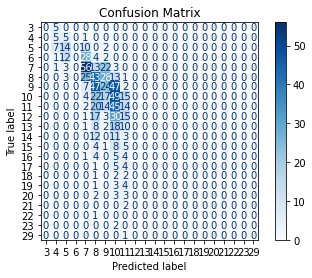

In [53]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,X_test,y_test,cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

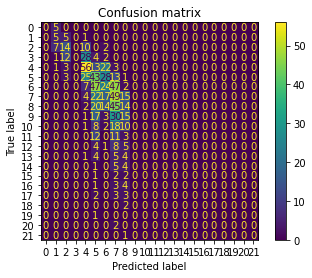

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_test_predicted=clf.predict(X_test)
cm=confusion_matrix(y_test,y_test_predicted)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion matrix')
plt.show()

In [56]:
from sklearn.metrics import classification_report
CR=classification_report(y_test,y_test_predicted)
print(CR)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.26      0.45      0.33        11
           5       0.38      0.42      0.40        33
           6       0.00      0.00      0.00        47
           7       0.41      0.57      0.48        98
           8       0.21      0.38      0.27       113
           9       0.21      0.19      0.20       127
          10       0.20      0.46      0.28       107
          11       0.16      0.15      0.16        95
          12       0.00      0.00      0.00        66
          13       0.00      0.00      0.00        39
          14       0.00      0.00      0.00        26
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        10
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
          20       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross Validation

In [57]:
from sklearn.model_selection import cross_val_score
acc=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10)
print(type(acc))
print('Accuracy after each fold:',list(acc*100))
print('Accuracy: {:.2f}%'.format(acc.mean()*100))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


<class 'numpy.ndarray'>
Accuracy after each fold: [27.46268656716418, 22.45508982035928, 23.952095808383234, 24.550898203592812, 24.251497005988025, 23.952095808383234, 25.449101796407188, 30.83832335329341, 26.34730538922156, 26.047904191616766]
Accuracy: 25.53%


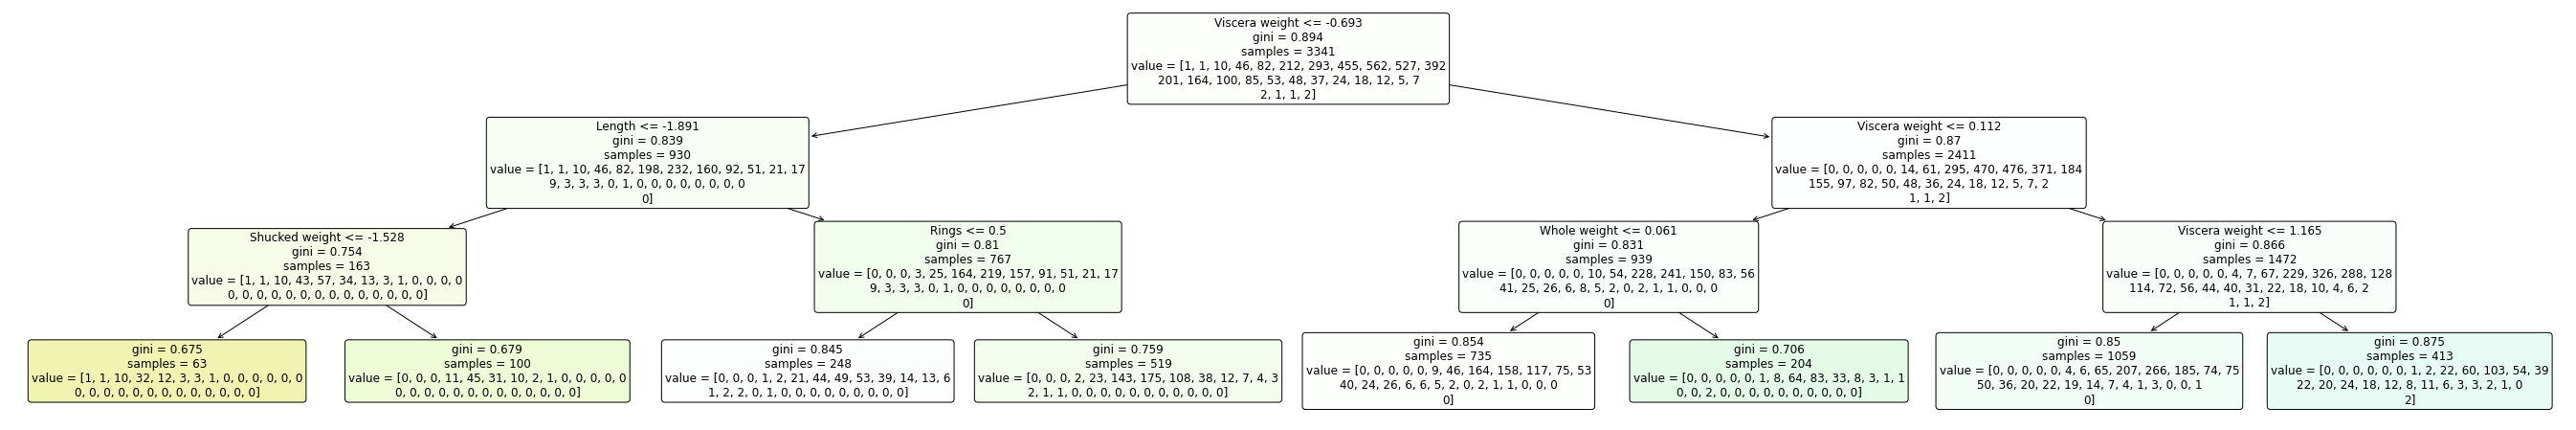

In [59]:
from sklearn import tree
plt.figure(figsize=(48,8),facecolor='w')
a=tree.plot_tree(clf['classifier'],
                 feature_names=column_names,
                 rounded=True,
                 filled=True,
                 fontsize=12)
plt.show()

## GridSearchCV

In [60]:
X_train_new=preprocessor.fit_transform(X_train)

In [63]:
from sklearn.model_selection import GridSearchCV
tuned_parameters=[{
    'max_depth':[1,2,3,4,5,6,7,8,9],
    'min_samples_split':[2,4,6,8,10]
}]

scores=['recall']
for score in scores:
  print()
  print(f'Tuning Hyperparameter for {score}\n')

  clf_CV=GridSearchCV(DecisionTreeClassifier(),
                      tuned_parameters,
                      scoring=f'{score}_macro')
  
  clf_CV.fit(X_train_new,y_train)

  print('Best Parameters:\n',clf_CV.best_params_)
  print('Grid Scores: ')
  means=clf_CV.cv_results_['mean_test_score']
  stds=clf_CV.cv_results_['std_test_score']

  for mean,std,params in zip(means,stds,clf_CV.cv_results_['params']):
    print(f'{mean:0.3f}(+/-{std*2:0.03f}) for {params}')



Tuning Hyperparameter for recall



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavio

Best Parameters:
 {'max_depth': 5, 'min_samples_split': 4}
Grid Scores: 
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 2}
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 4}
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 6}
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 8}
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 10}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 2}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 4}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 6}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 8}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 10}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 2}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 4}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 6}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 8}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 10}
0.134(+/-

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
clf2=Pipeline([
               ('preprocessor',preprocessor),
               ('classifier',DecisionTreeClassifier(
                   max_depth=5,min_samples_split=4,random_state=42
               ))
])

In [65]:
clf2.fit(X_train,y_train)
print('model score: %.3f'%clf2.score(X_test,y_test))

model score: 0.272


# **Decision Trees for Classification - Iris**

In [76]:
from sklearn.datasets import load_iris
features, labels=load_iris(as_frame=True,return_X_y=True)

In [77]:
features.shape

(150, 4)

In [78]:
train_features,test_features,train_labels,test_labels=train_test_split(
    features,labels,test_size=0.2,random_state=42
)

In [79]:
from sklearn.preprocessing import MinMaxScaler
dt_pipeline=Pipeline([
                      ('feature_scaling',MinMaxScaler()),
                      ('dt_classifier',DecisionTreeClassifier(max_depth=3,
                                                              random_state=42))
])

In [80]:
train_features.shape, train_labels.shape

((120, 4), (120,))

In [81]:
dt_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', MinMaxScaler()),
                ('dt_classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

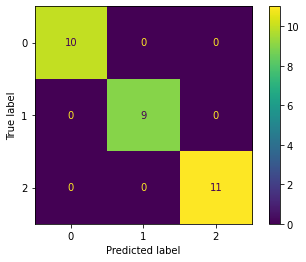

In [82]:
ConfusionMatrixDisplay.from_estimator(dt_pipeline,test_features, test_labels)

In [83]:
print(classification_report(test_labels,dt_pipeline.predict(test_features)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [84]:
data=load_iris()

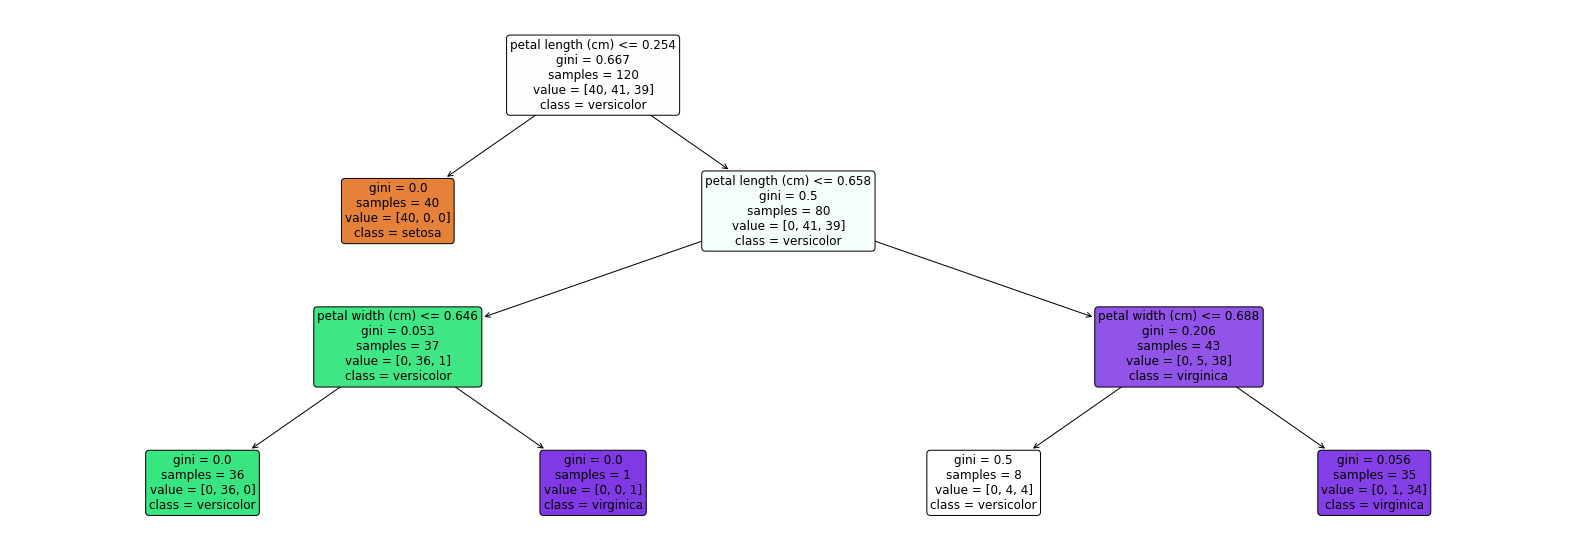

In [85]:
plt.figure(figsize=(28,10),facecolor='w')
a=tree.plot_tree(dt_pipeline[-1],
                 feature_names=features.columns,
                 class_names=data.target_names,
                 rounded=True,
                 filled=True,
                 fontsize=12)
plt.show()

In [87]:
tree_rules=export_text(dt_pipeline[-1],
                       feature_names=list(features.columns))
print(tree_rules)

|--- petal length (cm) <= 0.25
|   |--- class: 0
|--- petal length (cm) >  0.25
|   |--- petal length (cm) <= 0.66
|   |   |--- petal width (cm) <= 0.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  0.66
|   |   |--- petal width (cm) <= 0.69
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.69
|   |   |   |--- class: 2



In [89]:
importance=pd.DataFrame({'feature':features.columns,
                         'importance':np.round(
                             dt_pipeline[-1].feature_importances_,3)})
importance.sort_values('importance',ascending=False,inplace=True)

In [90]:
print(importance)

             feature  importance
2  petal length (cm)       0.935
3   petal width (cm)       0.065
0  sepal length (cm)       0.000
1   sepal width (cm)       0.000


In [91]:
hp_grid=[{'dt_classifier__max_depth':[1,2,3,4,5],
          'dt_classifier__min_samples_split':[2,4,6,8,10]}]
gs_clf=GridSearchCV(dt_pipeline,hp_grid,scoring='f1_macro')
gs_clf.fit(train_features,train_labels)

print('Best Parameters:\n',gs_clf.best_params_)

Best Parameters:
 {'dt_classifier__max_depth': 4, 'dt_classifier__min_samples_split': 2}


In [93]:
means=gs_clf.cv_results_['mean_test_score']
stds=gs_clf.cv_results_['std_test_score']
for mean, std, params in zip(means,stds,
                             gs_clf.cv_results_['params']):
  print(f'{mean:.3f}(+/-{std*2:0.03f}) for {params}')

0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 2}
0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 4}
0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 6}
0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 8}
0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 10}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 2}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 4}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 6}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 8}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 10}
0.932(+/-0.115) for {'dt_classifier__max_depth': 3, 'dt_classifier__min_samples_split': 

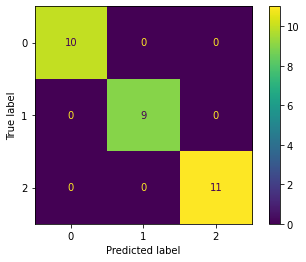

In [96]:
ConfusionMatrixDisplay.from_estimator(gs_clf.best_estimator_,test_features, test_labels )

# Practice Assignment

In [4]:
from sklearn.datasets import load_wine
X,y=load_wine(return_X_y=True,as_frame=True)
X.shape,y.shape

((178, 13), (178,))

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [6]:
X_train.shape,y_train.shape

((124, 13), (124,))

In [7]:
X_test.shape,y_test.shape

((54, 13), (54,))

In [11]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(random_state=1)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=1)

In [15]:
# @title Q1
dt.score(X_train,y_train)

1.0

In [18]:
# @title Q2
dt.score(X_test,y_test).round(3)

0.944

In [19]:
# @title Q3
dt.tree_.max_depth

6

In [24]:
# @title Q4
dt=DecisionTreeClassifier(criterion='entropy',
                          splitter='random',
                          max_depth=3,
                          min_samples_split=4,
                          min_impurity_decrease=0.1,
                          random_state = 1)

dt.fit(X_train,y_train)
dt.score(X_train,y_train)

0.8145161290322581

In [25]:
# @title Q5
dt.score(X_test,y_test)

0.7777777777777778

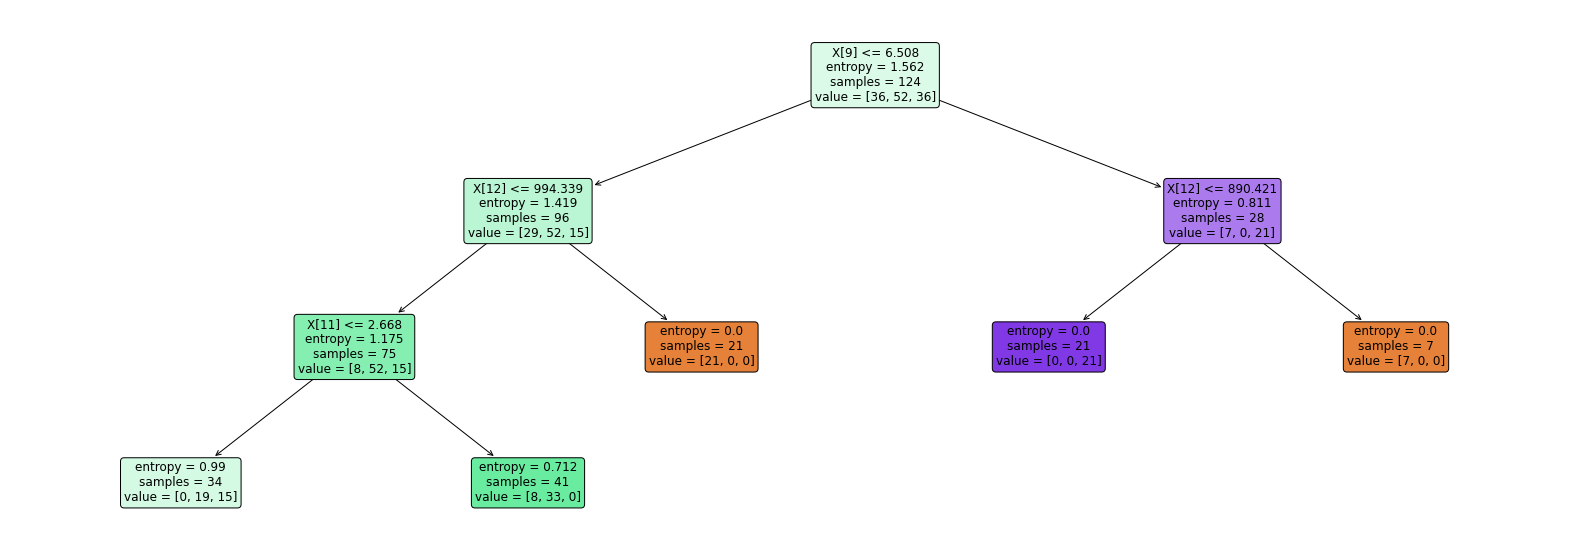

In [26]:
plt.figure(figsize=(28,10),facecolor='w')
a=tree.plot_tree(dt,
                #  feature_names=features.columns,
                #  class_names=data.target_names,
                 rounded=True,
                 filled=True,
                 fontsize=12)
plt.show()

# **Graded Assignment - 9**

In [27]:
X,y=load_wine(return_X_y=True,as_frame=True)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [28]:
from sklearn.model_selection import GridSearchCV
tuned_parameters=[{
    'max_depth':[3,4,5,6],
    'min_samples_split':[2,4,6,8,10],
    'splitter':['random','best'],
    'criterion':['entropy','gini']
}]

clf_CV=GridSearchCV(DecisionTreeClassifier(),
                      tuned_parameters,
                      cv=4)

In [30]:
clf_CV.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [3, 4, 5, 6],
                          'min_samples_split': [2, 4, 6, 8, 10],
                          'splitter': ['random', 'best']}])

In [32]:
clf_CV.score(X_train,y_train).round(3)

0.968

In [35]:
clf_CV.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_split': 6,
 'splitter': 'random'}

In [38]:
dt=DecisionTreeClassifier(
    criterion='entropy',
 max_depth= 6,
 min_samples_split= 6,
 splitter='random'
)
dt.fit(X_train,y_train)
dt.tree_.max_depth

5

In [39]:
from sklearn.datasets import load_diabetes
X,y=load_diabetes(return_X_y=True,as_frame=True)
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)

In [45]:
dt=DecisionTreeRegressor(criterion='squared_error',
                        splitter='random',
                         max_leaf_nodes=10,
                         random_state=1)
dt.fit(xtrain,ytrain)
dt.score(xtrain,ytrain).round(3)

0.503

In [46]:
dt.score(xtest,ytest).round(3)

0.219

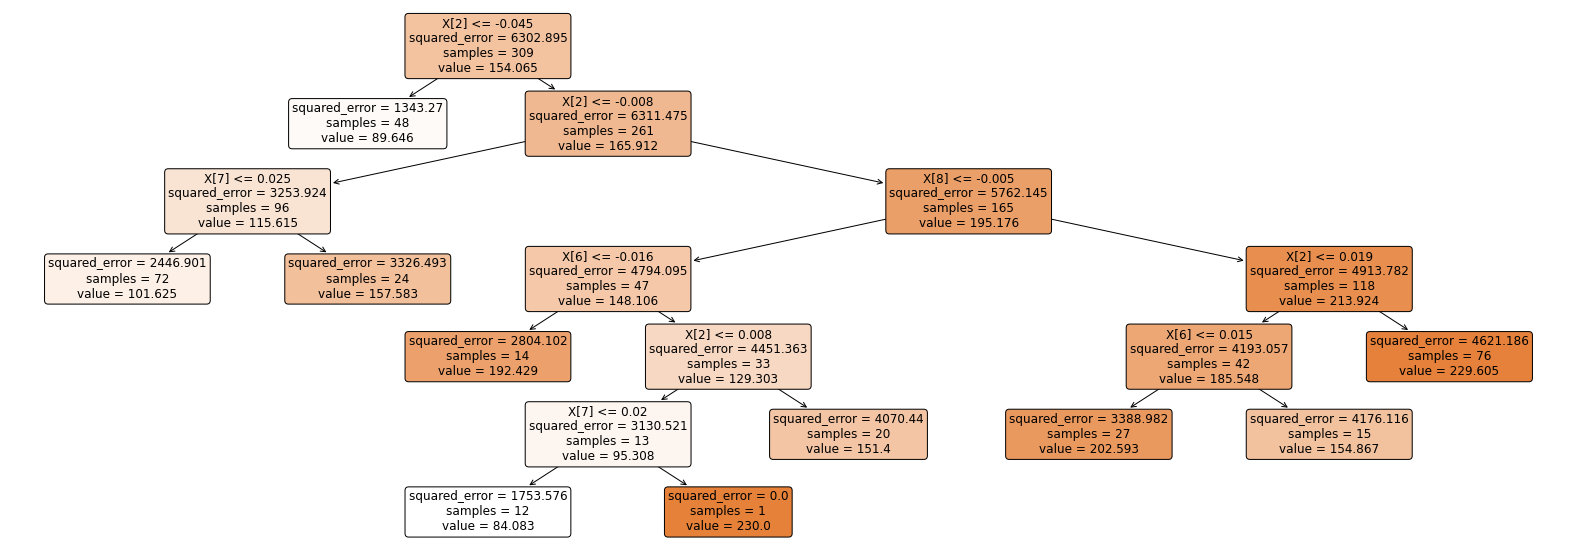

In [47]:
plt.figure(figsize=(28,10),facecolor='w')
a=tree.plot_tree(dt,
                #  feature_names=features.columns,
                #  class_names=data.target_names,
                 rounded=True,
                 filled=True,
                 fontsize=12)
plt.show()

In [56]:
from sklearn.model_selection import GridSearchCV
tuned_parameters=[{
    'max_depth':[3,4,5,6],
    'min_samples_split':[2,4,6,8,10],
    'splitter':['random','best'],
    'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_features':['auto','sqrt', 'log2'],
    'ccp_alpha': [0.001,0.01,0.02,0.05]
}]

clf_CV=GridSearchCV(DecisionTreeRegressor(max_depth = 4,random_state = 1),
                      tuned_parameters,
                      cv=4,
                    )

In [57]:
clf_CV.fit(xtrain,ytrain)


GridSearchCV(cv=4, estimator=DecisionTreeRegressor(max_depth=4, random_state=1),
             param_grid=[{'ccp_alpha': [0.001, 0.01, 0.02, 0.05],
                          'criterion': ['squared_error', 'friedman_mse',
                                        'absolute_error', 'poisson'],
                          'max_depth': [3, 4, 5, 6],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_split': [2, 4, 6, 8, 10],
                          'splitter': ['random', 'best']}])

In [58]:
clf_CV.score(xtest,ytest).round(3)

0.128

In [59]:
clf_CV.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_split': 2,
 'splitter': 'best'}

# **Graded Assignment - 8**

In [61]:
from sklearn.datasets import load_iris
X,y=load_iris(return_X_y=True,as_frame=True)
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=0)

In [62]:
from sklearn.svm import SVC
model=SVC(random_state=0)
param={'kernel': ['linear' , 'rbf'],
       'C':[1,15,25],
       'gamma':['auto'],
       }
gscv=GridSearchCV(model,
                  param,
                  cv=4)

In [63]:
gscv.fit(xtrain,ytrain)

GridSearchCV(cv=4, estimator=SVC(random_state=0),
             param_grid={'C': [1, 15, 25], 'gamma': ['auto'],
                         'kernel': ['linear', 'rbf']})

In [66]:
gscv.best_score_

0.9807692307692308

In [69]:
df=pd.read_csv('/content/Social_Network_Ads.csv')

In [70]:
df

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0
...,...,...,...
395,46,41000,1
396,51,23000,1
397,50,20000,1
398,36,33000,0


In [75]:
X=df.drop(columns='Purchased')

In [76]:
y=df.iloc[:,-1]

In [77]:
X.shape

(400, 2)

In [78]:
y.shape

(400,)

In [80]:
X=StandardScaler().fit_transform(X)
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.25,random_state = 0)

In [81]:
svc=SVC(random_state=0,kernel='linear')
svc.fit(xtrain,ytrain) 
svc.score(xtest,ytest)

0.9

In [83]:
from sklearn.metrics import confusion_matrix
ypred=svc.predict(xtest)
confusion_matrix(ytest,ypred)

array([[66,  2],
       [ 8, 24]])

In [88]:
from keras.datasets import mnist
(X),(y) = mnist.load_data()



In [90]:
X=np.array(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [91]:
X.shape

AttributeError: ignored